In [1]:
import os

from ufcdata.query import DatabaseQuery
from ufcdata.tools import query_to_df

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sb
import pickle as pkl

from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from umap import UMAP

import warnings
warnings.filterwarnings('ignore')

/Users/neelgokhale/miniforge3/envs/tfm1/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
ROOT_DIR = os.path.dirname(os.path.abspath("top_level_file.txt"))
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_PATH = os.path.join(DATA_DIR, 'data_1.pkl')
DATA_2_PATH = os.path.join(DATA_DIR, 'data_2.pkl')
DATA_3_PATH = os.path.join(DATA_DIR, 'data_3.pkl')
PIPE_PATH = os.path.join(DATA_DIR, 'pipeline.pkl')

In [3]:
with open(DATA_2_PATH, 'rb') as f:
    df = pkl.load(f)

df = df.dropna()
df

,sig_head_made_disp,kd_disp,ctrl_disp,sub_att_disp,takedown_made_disp,reversals_disp,sig_str_avoid_disp,takedown_avoid_disp,opp_ctrl_disp,opp_sig_str_made_disp,opp_takedown_made_disp
8,-6,0,-7.0,-1,1,-1,-14,0,7.0,21,-1
9,6,0,7.0,1,-1,1,14,0,-7.0,-21,1
10,30,0,246.0,0,2,0,-10,-2,-246.0,-31,-2
11,-30,0,-246.0,0,-2,0,10,2,246.0,31,2
39,4,0,262.0,0,2,0,3,-1,-262.0,-5,-2
...,...,...,...,...,...,...,...,...,...,...,...
31523,-6,0,120.0,-1,1,0,-5,1,-120.0,-5,-1
31524,-22,0,-127.0,1,-1,0,28,-3,127.0,36,1
31525,22,0,127.0,-1,1,0,-28,3,-127.0,-36,-1
31526,-26,0,-260.0,0,-2,0,18,0,260.0,58,2


In [23]:
preprocessor = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('umap', UMAP())
    ]
)

clusterer = Pipeline(
    [
        ('kmeans', KMeans(n_clusters=3))
    ]
)

pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('clusterer', clusterer)
    ]
)

parameters = {'preprocessor__scaler': [StandardScaler(), MinMaxScaler(), Normalizer()],
              'preprocessor__umap__n_neighbors': [5, 10, 15, 20, 25],
              'preprocessor__umap__min_dist': [0.5, 1],
              'clusterer__kmeans__n_clusters': [1, 2, 3, 4, 5]
             }

In [24]:
pipe.fit(df)

preprocessed_data = pipe['preprocessor'].transform(df.to_numpy())
labels = pipe['clusterer']['kmeans'].labels_

print(silhouette_score(preprocessed_data, labels))

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


0.47990498


In [4]:
grid = RandomizedSearchCV(pipe, parameters, cv=2, scoring='adjusted_rand_score').fit(df)

NameError: name 'pipe' is not defined

In [26]:
df_rand = pd.DataFrame.from_dict(grid.cv_results_, orient='columns')
df_rand

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessor__umap__n_neighbors,param_preprocessor__umap__min_dist,param_preprocessor__scaler,param_clusterer__kmeans__n_clusters,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,2.836790,0.072319,0.000919,8.358955e-04,25,1,StandardScaler(),5,"{'preprocessor__umap__n_neighbors': 25, 'prepr...",NaN,NaN,NaN,NaN,1
1,2.200183,0.024326,0.000107,2.849102e-05,10,1,Normalizer(),2,"{'preprocessor__umap__n_neighbors': 10, 'prepr...",NaN,NaN,NaN,NaN,2
2,2.366336,0.055249,0.000125,4.684925e-05,10,0.5,Normalizer(),1,"{'preprocessor__umap__n_neighbors': 10, 'prepr...",NaN,NaN,NaN,NaN,3
3,2.134420,0.040323,0.000081,5.960464e-07,10,1,MinMaxScaler(),3,"{'preprocessor__umap__n_neighbors': 10, 'prepr...",NaN,NaN,NaN,NaN,4
4,2.107798,0.172644,0.000083,6.079674e-06,5,0.5,StandardScaler(),1,"{'preprocessor__umap__n_neighbors': 5, 'prepro...",NaN,NaN,NaN,NaN,5
5,2.417289,0.481306,0.000146,4.541874e-05,5,1,MinMaxScaler(),5,"{'preprocessor__umap__n_neighbors': 5, 'prepro...",NaN,NaN,NaN,NaN,6
6,2.796683,0.040315,0.000131,3.910065e-05,25,0.5,Normalizer(),3,"{'preprocessor__umap__n_neighbors': 25, 'prepr...",NaN,NaN,NaN,NaN,7
7,2.874008,0.073612,0.000081,4.768372e-07,25,1,StandardScaler(),3,"{'preprocessor__umap__n_neighbors': 25, 'prepr...",NaN,NaN,NaN,NaN,8
8,2.712369,0.010341,0.000088,2.026558e-06,25,0.5,MinMaxScaler(),1,"{'preprocessor__umap__n_neighbors': 25, 'prepr...",NaN,NaN,NaN,NaN,9
9,2.311656,0.080666,0.000078,1.192093e-07,10,0.5,Normalizer(),5,"{'preprocessor__umap__n_neighbors': 10, 'prepr...",NaN,NaN,NaN,NaN,10


In [27]:
best = grid.best_params_
best

{'preprocessor__umap__n_neighbors': 25,
 'preprocessor__umap__min_dist': 1,
 'preprocessor__scaler': StandardScaler(),
 'clusterer__kmeans__n_clusters': 5}

In [5]:
preprocessor = Pipeline(
    [
        ('scaler', StandardScaler()),
        ('umap', UMAP(n_neighbors=50))
    ]
)

clusterer = Pipeline(
    [
        ('kmeans', KMeans(n_clusters=5))
    ]
)

pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('clusterer', clusterer)
    ]
)

In [ ]:
pipeline.fit(df)

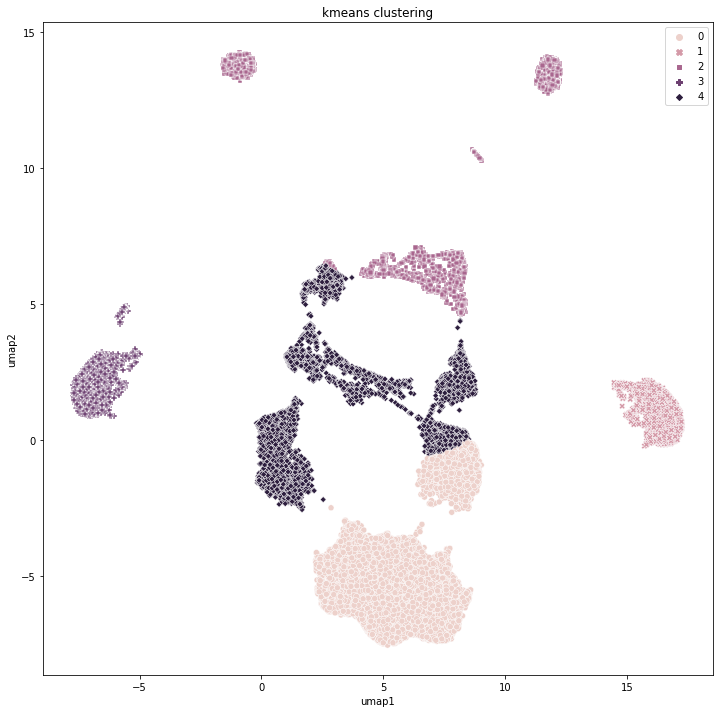

In [30]:
df_emb = pd.DataFrame(
    pipeline['preprocessor'].transform(df.to_numpy()),
    columns=['umap1', 'umap2']
)

df_emb['cluster'] = pipeline['clusterer']['kmeans'].labels_

fig, ax = plt.subplots(figsize=(12, 12))

scatter = sb.scatterplot(
    'umap1',
    'umap2',
    data=df_emb,
    hue='cluster',
    style='cluster',
    ax=ax
)

ax.set(xlabel='umap1', ylabel='umap2', title='kmeans clustering')
ax.legend()

In [31]:
print(df_emb.groupby(by='cluster').mean())

             umap1     umap2
cluster                     
0         5.816073 -4.623484
1        16.132635  1.025001
2         6.250863  9.704510
3        -6.553234  2.350058
4         3.399070  1.605535


# Fighter Strategy (Control Time)

In [7]:
with open(DATA_3_PATH, 'rb') as f:
    df3 = pkl.load(f)

df3 = df3.dropna()
data = df3[['ctrl_per', 'standing_per']].to_numpy()
df3

,ctrl_per,standing_per,opp_ctrl_per
8,0.010000,0.956667,0.033333
9,0.033333,0.956667,0.010000
10,0.820000,0.180000,0.000000
11,0.000000,0.180000,0.820000
39,0.873333,0.126667,0.000000
...,...,...,...
31523,0.400000,0.600000,0.000000
31524,0.026667,0.523333,0.450000
31525,0.450000,0.523333,0.026667
31526,0.000000,0.133333,0.866667


[Text(0.5, 0, 'ctrl %'),
 Text(0, 0.5, 'standing %'),
 Text(0.5, 1.0, 'Fighter Control Time')]

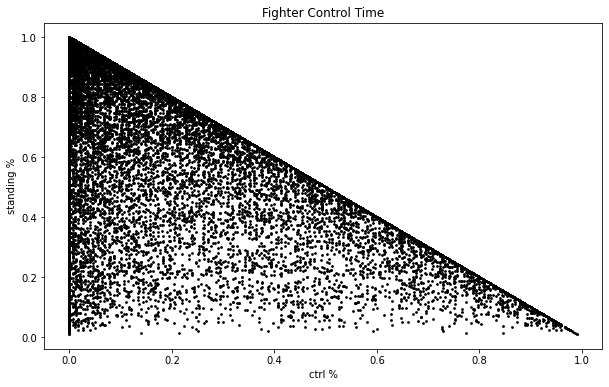

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(df3['ctrl_per'], df3['standing_per'], s=3, color='black')
ax.set(xlabel='ctrl %', ylabel='standing %', title='Fighter Control Time')

In [22]:
preprocessor = Pipeline(
    [
        ('umap', UMAP(n_neighbors=25))
    ]
)

clusterer = Pipeline(
    [
        ('kmeans', KMeans(n_clusters=6, init='k-means++'))
    ]
)

pipeline = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('clusterer', clusterer)
    ]
)

In [23]:
pipeline.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('umap',
                                  UMAP(n_neighbors=25, tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True}))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans', KMeans(n_clusters=6))]))])

0.41103363


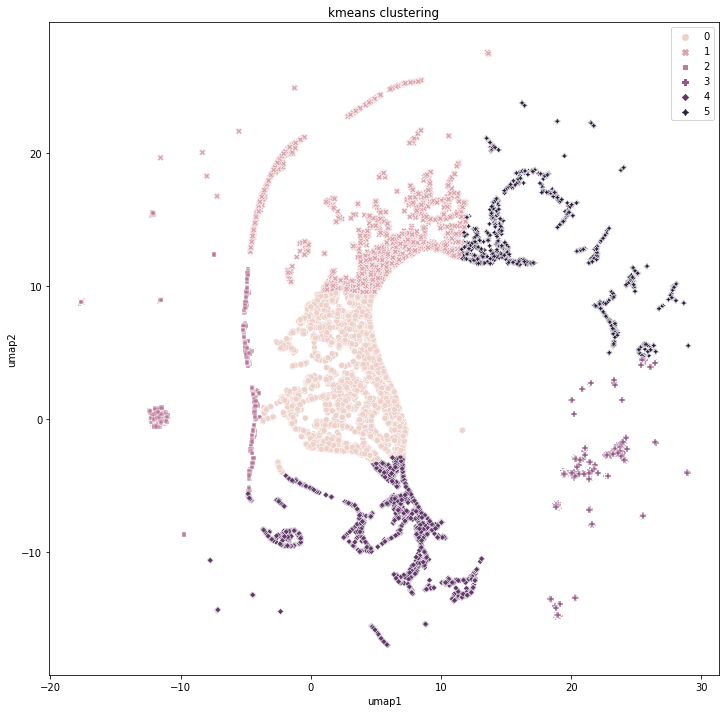

In [24]:
preprocessed_data = pipeline['preprocessor'].transform(data)
labels = pipeline['clusterer']['kmeans'].labels_

print(silhouette_score(preprocessed_data, labels))

# GRAPHING CLUSTERS

df_emb = pd.DataFrame(
    pipeline['preprocessor'].transform(data),
    columns=['umap1', 'umap2']
)

df_emb['cluster'] = pipeline['clusterer']['kmeans'].labels_
df_emb[['ctrl_avg', 'standing_avg']] = pipeline['preprocessor'].inverse_transform(df_emb[['umap1', 'umap2']])

fig, ax = plt.subplots(figsize=(12, 12))

scatter = sb.scatterplot(
    'umap1',
    'umap2',
    data=df_emb,
    hue='cluster',
    style='cluster',
    ax=ax
)

ax.set(xlabel='umap1', ylabel='umap2', title='kmeans clustering')
ax.legend()

In [25]:
print(df_emb.groupby(by='cluster').mean())

             umap1      umap2  ctrl_avg  standing_avg
cluster                                              
0         2.926457   2.505969  0.233954      0.415248
1         3.880055  16.324884  0.110008      0.726399
2       -10.056961   3.268027  0.002929      0.818761
3        21.648626  -4.917120  0.007701      0.976577
4         4.748813  -9.046259  0.543121      0.283660
5        19.875126  13.315014  0.051365      0.890737


In [27]:
with open(PIPE_PATH, 'wb') as f:
    pkl.dump(pipeline, f)